In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline 

In [12]:
def col_del(data, cols):
    try:
        for col in cols:
            del data[col]
    except:
        print("Столбец не найден")

In [4]:
def nul_deletion(data, coef):
    for col in data.columns:
        temp_null_count = data[data[col].isnull()].shape[0]
        if temp_null_count>data[col].shape[0]*coef:
            del data[col]
        else:
            if data[col].dtype != 'O':
                data[col]=data[col].fillna(data[col].median())
    data.fillna(method='bfill', inplace =True)
    data.fillna(method='ffill', inplace =True)

In [5]:
def stats_aggregation(stats):
    first_keys=['Player_id','Year', 'Age', 'Player', 'Pos', 'Tm']
    col_agg_d= {}
    col_agg_d.update(dict.fromkeys(first_keys, lambda d: d.iloc[0]))
    col_agg_d.update(dict.fromkeys(stats.columns[6:], np.mean))
    stats=stats.groupby(['Player']).agg(col_agg_d).sort_values(('Player_id'), ascending=True)
    stats = stats.reset_index(drop=True)
    for i in range(stats.shape[0]):
        stats.at[i, 'Player_id'] = i
    stats.head()

In [6]:
def data_preprocessing(players, stats):
    players.dropna(subset=['Player'], how='all', inplace = True)
    stats.dropna(subset=['Player'], how='all', inplace = True)
    try:
        del stats['blanl']
        del stats['blank2']
    except:
        print('уже удалено')
    nul_deletion(players, 0.3)
    nul_deletion(stats, 0.3)
    players.rename(columns={'Unnamed: 0': 'Player_id'}, inplace=True)
    stats.rename(columns={'Unnamed: 0': 'Player_id'}, inplace=True)
    stats_aggregation(stats)
    players_with_stats = merge_data(players, stats)
    col_del(players_with_stats, ['Tm','collage', 'born', 'birth_city', 'birth_state', 'Year', 'BPM', '2P%', 
                             'FT', 'FTA', 'FG%', 'TS%', 'MP', '2PA', 'FGA', 'WS', '3PA', 'FG', 'TRB%'])
    players_with_stats['Pos'].replace(to_replace = ['PF-C', 'PF-SF', 'PG-SG', 'SF-PF', 'SF-SG', 'SG-PG', 'SG-SF'], 
                                  value = ['PF', 'PF', 'PG', 'SF', 'SF','SG', 'SG'],inplace = True)
    players_with_stats['Pos'].replace(to_replace = ['G-F', 'F', 'G', 'F-C', 'F-G', 'C-F', 'C-PF'], 
                                  value = ['SG', 'PF', 'PG', 'PF', 'SF', 'C', 'C'],inplace = True)
    Pos = players_with_stats['Pos']
    le = LabelEncoder()
    pos_le = le.fit_transform(players_with_stats['Pos'])
    pws = players_with_stats
    col_del(pws, ['Pos','Player_id', 'Player'])
    pws_norm = normalize(pws)
    return pws_norm, pos_le

In [7]:
def read_data(player_pth, stats_pth):
    players = pd.read_csv(player_pth)
    stats = pd.read_csv(stats_pth)
    return players, stats

In [8]:
def merge_data(players, stats):
    players_with_stats = pd.merge(players, stats, left_on='Player_id', right_on='Player_id', how='inner')
    players_with_stats.rename(columns={'Player_x': 'Player'}, inplace=True)
    try:
        del players_with_stats['Player_y']
    except:
        pass
    return players_with_stats

In [13]:
X, Y = data_preprocessing(*read_data('Players.csv', 'Seasons_Stats.csv'))

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [84]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [97]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data   
    classes = classes[unique_labels(y_true, y_pred)-1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Метка 	 Accuracy
0 	 0.6086956521739131
1 	 0.0
2 	 0.5289855072463768
3 	 0.8175675675675675
5 	 0.379746835443038
Confusion matrix, without normalization


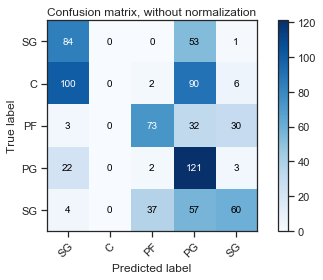

In [98]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state = 42)
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)
y_pred = sgd.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, 
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')

In [61]:
def GridSearch_with_other_val(model, parameters):
    results=[]
    val_methods = [KFold(n_splits = 5), ShuffleSplit(n_splits = 5, test_size = 0.25)]
    i=0
    for score in score_methods:
        i+=1
        grid = GridSearchCV(model, parameters, cv = score)
        grid.fit(X_train, y_train)
        results.append([i, ')', grid.best_estimator_, ': ', grid.best_score_])
    return results

In [40]:
sgd_parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
                  'max_iter': list(range(1000, 10000, 1000)), 'random_state': [42]}
sgd_results = GridSearch_with_other_val(sgd, sgd_parameters)

c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarnin

In [41]:
sgd_results

[[1, ')', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=9000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False), ': ', 0.4606993904395252],
 [2, ')', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=4000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False), ': ', 0.46282051282051284]]

Метка 	 Accuracy
0 	 0.12318840579710146
1 	 0.5808080808080808
2 	 0.7028985507246377
3 	 0.5
5 	 0.4620253164556962
Confusion matrix, without normalization


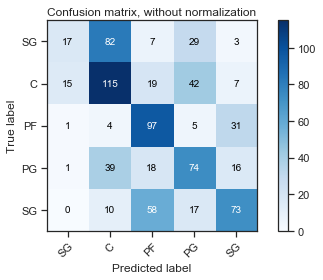

In [101]:
sgd = SGDClassifier(loss = 'log' ,max_iter=9000, tol=1e-3)
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)
y_pred = sgd.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, 
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')

Метка 	 Accuracy
0 	 0.0
1 	 0.8535353535353535
2 	 0.0
3 	 0.20270270270270271
5 	 0.7278481012658228
Confusion matrix, without normalization


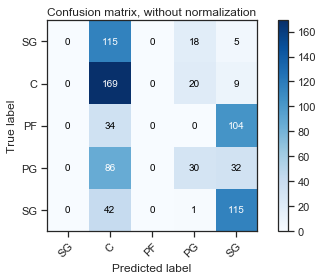

In [99]:
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)
y_pred = svc.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, 
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')

In [63]:
svc_parameters = {'kernel': ['linear', 'poly', 'rbf']}
svc_results = GridSearch_with_other_val(svc, svc_parameters)

In [64]:
svc_results

[[1, ')', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), ': ', 0.4629451395572666],
 [2, ')', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), ': ', 0.4723076923076923]]

Метка 	 Accuracy
0 	 0.2463768115942029
1 	 0.6161616161616161
2 	 0.463768115942029
3 	 0.41216216216216217
5 	 0.5886075949367089
Confusion matrix, without normalization


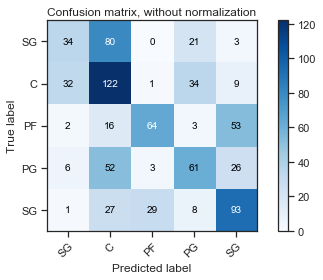

In [100]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)
y_pred = svc.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, 
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')

Метка 	 Accuracy
0 	 0.41304347826086957
1 	 0.3838383838383838
2 	 0.5362318840579711
3 	 0.4527027027027027
5 	 0.43670886075949367
Confusion matrix, without normalization


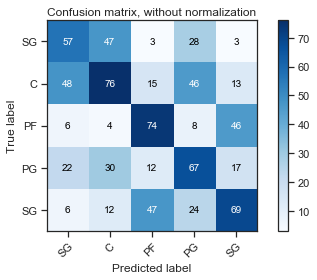

In [102]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
y_pred = tree.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, 
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')

In [73]:
tree_parameters = {'max_depth': list(range(3, 50, 2)), 
                  'max_leaf_nodes': list(range(2, 25, 2)), 'random_state': [42]}
tree_results = GridSearch_with_other_val(tree, tree_parameters)

In [74]:
tree_results

[[1,
  ')',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
              max_features=None, max_leaf_nodes=24,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best'),
  ': ',
  0.4748155277510427],
 [2,
  ')',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
              max_features=None, max_leaf_nodes=24,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best'),
  ': ',
  0.48128205128205126]]

Метка 	 Accuracy
0 	 0.43478260869565216
1 	 0.2828282828282828
2 	 0.6231884057971014
3 	 0.4797297297297297
5 	 0.5253164556962026
Confusion matrix, without normalization


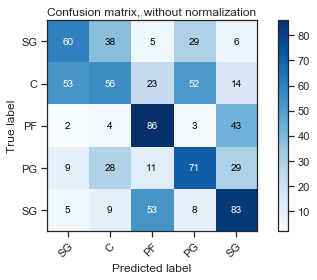

In [103]:
tree = DecisionTreeClassifier(max_depth = 5, max_leaf_nodes = 24 ,random_state=42)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
y_pred = tree.predict(X_test)
print_accuracy_score_for_classes(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred,
                      classes=np.array(['C', 'PF', 'PG', 'SF', 'SG']),
                      title='Confusion matrix, without normalization')